# This is the main analysis for the monkey pox trend

This analysis uses the open source data from Kaggle (https://www.kaggle.com/datasets/deepcontractor/monkeypox-dataset-daily-updated).

## Import data

Import data from local directory.

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

top = os.getcwd()
for root, _, files in os.walk(top):
    for file in files:
        if file.endswith(".csv"):
             print(os.path.join(root, file))

E:\Data_Project\MonkeyPox_Ana\Daily_Country_Wise_Confirmed_Cases.csv
E:\Data_Project\MonkeyPox_Ana\Monkey_Pox_Cases_Worldwide.csv
E:\Data_Project\MonkeyPox_Ana\Worldwide_Case_Detection_Timeline.csv


In [154]:
country_daily_cases = pd.read_csv('Daily_Country_Wise_Confirmed_Cases.csv')
worldwide_cases = pd.read_csv('Monkey_Pox_Cases_Worldwide.csv')
worldwide_detection_timeline = pd.read_csv('Worldwide_Case_Detection_Timeline.csv')

In [155]:
country_daily_cases.head(10)

,Country,2022-05-06,2022-05-12,2022-05-13,2022-05-15,2022-05-17,2022-05-18,2022-05-19,2022-05-20,2022-05-21,...,2022-06-27,2022-06-28,2022-06-29,2022-06-30,2022-07-01,2022-07-02,2022-07-03,2022-07-04,2022-07-05,2022-07-06
0,England,1,1,1,4,0,2,0,11,0,...,0,0,0,150,0,0,0,100,0,0
1,Portugal,0,0,0,0,3,11,9,0,0,...,17,8,18,11,18,0,0,0,13,0
2,Spain,0,0,0,0,0,7,0,23,10,...,64,0,0,396,0,0,0,62,0,0
3,United States,0,0,0,0,0,1,0,1,0,...,43,62,45,44,64,0,0,0,100,45
4,Germany,0,0,0,0,0,0,1,1,2,...,145,65,35,64,105,1,7,97,105,0
5,Belgium,0,0,0,0,0,0,1,2,1,...,0,40,0,0,0,0,0,0,51,0
6,Sweden,0,0,0,0,0,0,1,0,0,...,0,0,0,15,0,0,0,0,0,0
7,Italy,0,0,0,0,0,0,1,2,0,...,0,32,0,0,33,0,0,0,41,0
8,Canada,0,0,0,0,0,0,2,3,0,...,22,18,12,0,0,25,0,37,0,0
9,France,0,0,0,0,0,0,1,0,0,...,0,109,0,58,0,0,0,0,79,0


In [156]:
worldwide_cases.head(10)

,Country,Confirmed_Cases,Suspected_Cases,Hospitalized,Travel_History_Yes,Travel_History_No
0,England,1285.0,0.0,5.0,2.0,7.0
1,Portugal,433.0,0.0,0.0,0.0,34.0
2,Spain,1258.0,0.0,11.0,2.0,0.0
3,United States,604.0,0.0,4.0,20.0,1.0
4,Canada,349.0,9.0,1.0,2.0,0.0
5,Sweden,28.0,0.0,0.0,0.0,0.0
6,Italy,233.0,1.0,18.0,19.0,4.0
7,France,577.0,1.0,1.0,2.0,1.0
8,Belgium,168.0,1.0,2.0,1.0,0.0
9,Australia,17.0,0.0,2.0,8.0,0.0


In [157]:
worldwide_detection_timeline.head(10)

,Date_confirmation,Country,City,Age,Gender,Symptoms,Hospitalised (Y/N/NA),Isolated (Y/N/NA),Travel_history (Y/N/NA)
0,2022-05-06,England,London,NaN,NaN,rash,Y,Y,Y
1,2022-05-12,England,London,NaN,NaN,rash,Y,Y,N
2,2022-05-13,England,London,NaN,NaN,vesicular rash,N,Y,N
3,2022-05-15,England,London,NaN,male,vesicular rash,Y,Y,N
4,2022-05-15,England,London,NaN,male,vesicular rash,Y,Y,N
5,2022-05-15,England,London,NaN,male,vesicular rash,NaN,Y,N
6,2022-05-15,England,Newcastle,NaN,male,vesicular rash,Y,Y,Y
7,2022-05-17,Portugal,Lisbon,20-44,male,"skin lesions, ulcerative lesions",N,NaN,N
8,2022-05-17,Portugal,Lisbon,20-44,male,"skin lesions, ulcerative lesions",N,NaN,N
9,2022-05-17,Portugal,Lisbon,20-44,male,"skin lesions, ulcerative lesions",N,NaN,N


## Preliminary analysis
1. show the trends of 20 countries that have the highest overall case numbers

In [158]:
ndays = len(country_daily_cases.columns)-1
case_sums  = np.array(country_daily_cases.iloc[:,1:ndays].sum(axis = 1))
case_sums_sort_desc = np.sort(case_sums)[::-1]
index_casesums_sort_desc = np.argsort(case_sums)[::-1]
country_daily_cases_desc = country_daily_cases.iloc[index_casesums_sort_desc,:]

In [159]:
ncountry_toplot = 20
country_daily_cases_worst = country_daily_cases_desc.iloc[np.arange(0,ncountry_toplot,1),:]
country_daily_cases_worst

,Country,2022-05-06,2022-05-12,2022-05-13,2022-05-15,2022-05-17,2022-05-18,2022-05-19,2022-05-20,2022-05-21,...,2022-06-27,2022-06-28,2022-06-29,2022-06-30,2022-07-01,2022-07-02,2022-07-03,2022-07-04,2022-07-05,2022-07-06
0,England,1,1,1,4,0,2,0,11,0,...,0,0,0,150,0,0,0,100,0,0
2,Spain,0,0,0,0,0,7,0,23,10,...,64,0,0,396,0,0,0,62,0,0
4,Germany,0,0,0,0,0,0,1,1,2,...,145,65,35,64,105,1,7,97,105,0
9,France,0,0,0,0,0,0,1,0,0,...,0,109,0,58,0,0,0,0,79,0
3,United States,0,0,0,0,0,1,0,1,0,...,43,62,45,44,64,0,0,0,100,45
1,Portugal,0,0,0,0,3,11,9,0,0,...,17,8,18,11,18,0,0,0,13,0
11,Netherlands,0,0,0,0,0,0,0,1,1,...,46,0,0,0,0,0,0,95,0,0
8,Canada,0,0,0,0,0,0,2,3,0,...,22,18,12,0,0,25,0,37,0,0
7,Italy,0,0,0,0,0,0,1,2,0,...,0,32,0,0,33,0,0,0,41,0
5,Belgium,0,0,0,0,0,0,1,2,1,...,0,40,0,0,0,0,0,0,51,0


2. plot the trends of the ten worst countries

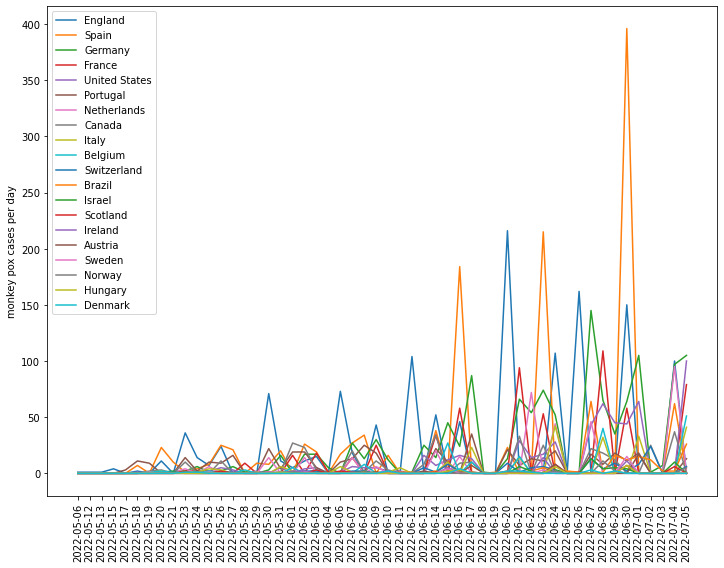

In [160]:
fig= plt.figure(figsize=(12,9))
#
# plot case per day
for icount in np.arange(0,ncountry_toplot,1):
    plt.plot(country_daily_cases_worst.iloc[icount,1:ndays])
plt.legend(country_daily_cases_worst.iloc[:,0])    
plt.xticks(rotation = 90)
plt.ylabel("monkey pox cases per day");

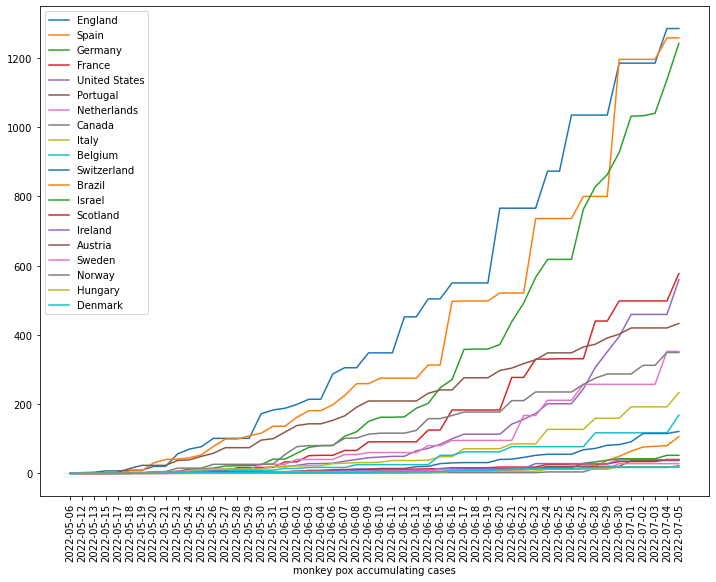

In [161]:
# plot accumulating case
country_daily_cases_desc_accum = country_daily_cases_desc.copy()
for iday in np.arange(2,ndays+1,1):
    country_daily_cases_desc_accum.iloc[:,iday] = country_daily_cases_desc_accum.iloc[:,iday]+country_daily_cases_desc_accum.iloc[:,iday-1]
#
fig= plt.figure(figsize=(12,9))
#
country_daily_cases_worst_accum = country_daily_cases_desc_accum.iloc[np.arange(0,ncountry_toplot,1),:]
for icount in np.arange(0,ncountry_toplot,1):
    plt.plot(country_daily_cases_worst_accum.iloc[icount,1:ndays])
plt.legend(country_daily_cases_worst_accum.iloc[:,0])    
plt.xticks(rotation = 90)
plt.ylabel("monkey pox accumulating cases");
    

3. Show the trend for all the countries altogether

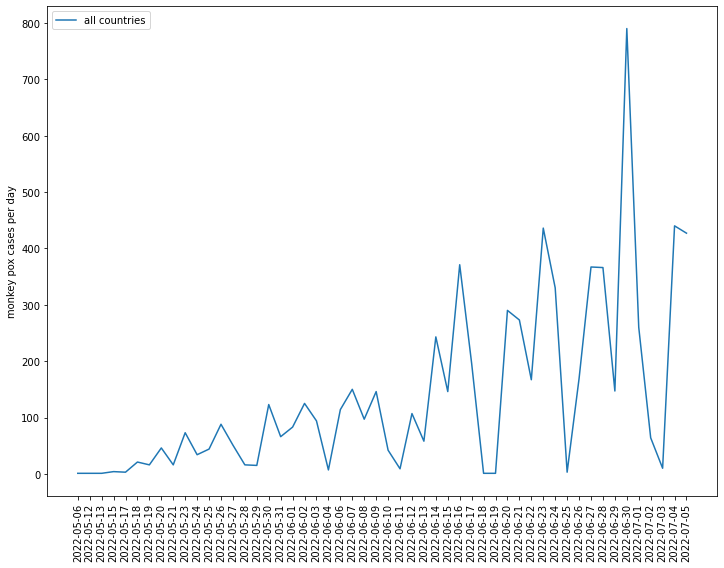

In [167]:
fig= plt.figure(figsize=(12,9))
#
# plot case per day
allcountry_daily_cases = country_daily_cases.iloc[:,1:ndays].sum(axis = 0)
plt.plot(allcountry_daily_cases)
plt.legend(["all countries"])    
plt.xticks(rotation = 90)
plt.ylabel("monkey pox cases per day");

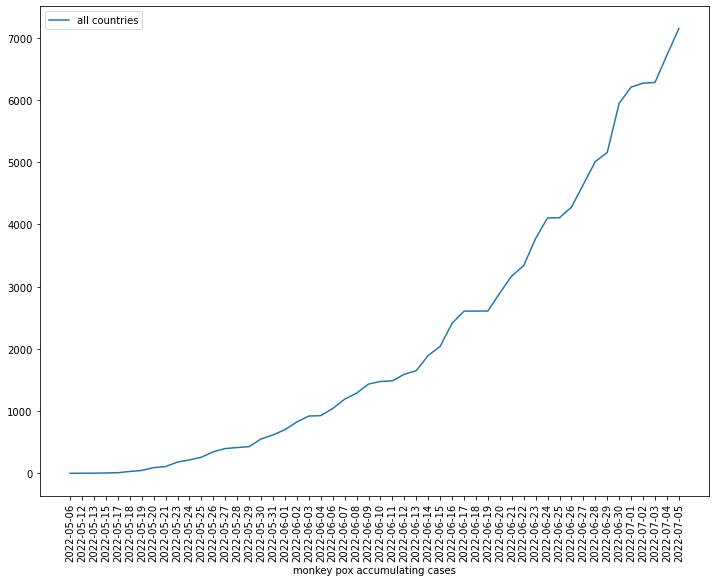

In [185]:
allcountry_daily_cases_accum = allcountry_daily_cases.copy()
for iday in np.arange(1,ndays-1,1):
    allcountry_daily_cases_accum[iday] = allcountry_daily_cases_accum[iday]+allcountry_daily_cases_accum[iday-1]
#
fig= plt.figure(figsize=(12,9))
#
plt.plot(allcountry_daily_cases_accum)
plt.legend(["all countries"])    
plt.xticks(rotation = 90)
plt.ylabel("monkey pox accumulating cases");